In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Řešení úlohy 2D průhybu membrány
V této úloze se pokusíme vyřešit úlohu
\begin{align*}
        -\Delta u_m&= f\:\:\mathrm{na}\:\:\Omega_m ,\:\:m=1,2\\
        u_1&=0\:\:\mathrm{na}\:\:\Gamma_{u},\\
        t_m:=\frac{du_m}{dn_m}&=0\:\:\mathrm{na}\:\:\Gamma_{mf},\:\:m=1,2\\
        u_2-u_1&\geq 0\:\:\mathrm{na}\:\:\Gamma_{c},\\
        t_2&\geq 0\:\:\mathrm{na}\:\:\Gamma_{c},\\
        t_2(u_2-u_1)&=0\:\:\mathrm{na}\:\:\Gamma_{c},\\
        t_1+t_2&=0\:\:\mathrm{na}\:\:\Gamma_{c},
\end{align*}
kde 
$n_m$ je vnější jednotkový normálový vektor oblasti $\Omega_m,\:m=1,2,$ a 
\begin{align*}
\Omega_1&=\{(x,y)\in\mathbb{R}:\:0<x<1\:\wedge\:0<y<1\},\:\: &\Omega_2&=\{(x,y)\in\mathbb{R}:\:1<x<2\:\wedge\:0<y<1\},\\
\Gamma_u&=\{(0,y)\in\mathbb{R}:\:0\leq y\leq 1\},\:\:&\Gamma_c&=\{(1,y)\in\mathbb{R}:\:0\leq y\leq 1\},\\
\Gamma_{1f}&=\partial\Omega_1\setminus\{\Gamma_u\cup\Gamma_c\},\: &\Gamma_{2f}&=\partial\Omega_2\setminus\Gamma_c.
\end{align*}

Zvolíme také 
\begin{equation*}
f=
\begin{cases} 
      -3 & x\in(0,1)\:\:\wedge\:\:y\in\langle\frac{3}{4},1), \\
      -1 & x\in(1,2)\:\:\wedge\:\:(0,\frac{1}{4}\rangle,\\
      0 & \mathrm{jinde\:\:v\:\:}\Omega_1\cup\Omega_2.
   \end{cases}
\end{equation*}

Tato úloha popisuje situaci průhybu dvou membrán, z nichž levá ($\Omega_1$) je upevněna na hranici $\Gamma_u$, obě membrány jsou volné na hranicích $\Gamma_{1f},\:\Gamma_{2f}$ a pravá membrána ($\Omega_2$) se volně vznáší. Na obě membrány působí vertikální síla $f$. V případě, že se membrány dotknou na hranici $\Gamma_c$, nemůže pravá membrána klesnout pod levou na této hranici.

Použijeme dvě neuronové sítě, každou s 5 skrytými vrstvami se 30 neurony s aktivační funkcí $Tanh$ v každé vrstvě. Každá z NN bude aproximovat řešení pro danou membránu, a vzájemně je provážeme kontaktními podmínkami.
Použijeme optimalizátor Adam s rychlostí učení $10^{-3}$.
Provedeme učení po dávkách s velikostí dávky 32 na 5000 epochách.
Trénování provedeme na 5000 trénovacích bodech uvnitř oblastí a 140 bodech na hranicích oblastí.

Proces definice, učení a testování neuronové sítě je rozdělen do několika kroků:

**Krok 1:**
Definujeme architekturu neuronové sítě.
Vytvoříme pomocné funkce:
- `f()` dle zadání, jen místo nespojité funkce definované v zadání použijeme sigmoidu se skokem v odpovídajcích bodech. Důvodem je lepší funkčnost NN při práci se spojitou funkcí,
- `sample_points()` pro vygenerování trénovacích dat,
- `plot_boundaries()` pro vykreslení trénovacích bodů,
- `compute_derivatives_2d()` pro výpočet derivací s využitím utility `autograd.grad` z knihovny `PyTorch`,
- `compute_normal_derivative()` pro výpočet normálové derivace,
- `compute_laplacian()` pro výpočet Laplaciánu,
- `generate_random_data()` pro vygenerování náhodně rozložených testovacích dat,
- `generate_square_domain()` pro vygenerování rovnoměrně rozložených testovacích dat a vykreslení predikce řešení NN pro tyto data,
- `plot_predictions_random()` pro vykreslení predikce řešení NN pro náhodně rozložená data,
- `plot_predictions_equal()` pro vykreslení predikce řešení NN pro rovnoměrně rozložená data.

**Krok 2:** 
Definujeme dílčí ztrátové funkce pro podmínky ze zadání úlohy. Tyto ztrátové funkce jsou poté v trénovací smyčce sečteny.

**Krok 3:**
Vygenerujeme 5000 rovnoměrně rozložených tréninkových bodů uvnitř oblastí a 140 rovnoměrně rozložených bodů na hranicích oblastí.

**Krok 4:**
Inicializujeme neuronovou síť a nastavíme optimalizátor Adam s mírou učení $10^{-3}$.

**Krok 5:**
Spustíme smyčku pro učení NN na 5000 epoch. Vykreslíme graf znázorňující závislost ztráty na počtu epoch.

**Krok 6:**
Otestujeme NN na náhodně i rovnoměrně rozložených testovacích datech a vykreslíme predikce řešení.

In [2]:
# Krok 1.1: Definice architektury NN
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(2, 30)  # Vstup je 2D, proto 2 vstupy (x,y)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(30, 30)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(30, 30)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(30, 30)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(30, 30)
        self.tanh5 = nn.Tanh()
        self.fc6 = nn.Linear(30, 1)  # Výstup je skalár u(x,y)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.tanh2(x)
        x = self.fc3(x)
        x = self.tanh3(x)
        x = self.fc4(x)
        x = self.tanh4(x)
        x = self.fc5(x)
        x = self.tanh5(x)
        x = self.fc6(x)
        return x

In [3]:
# Krok 1.2: Definice funkce f(x,y) pomocí sigmoid
def force_function(y, side):
    # Funkce zatížení definovaná pomocí sigmoidy
    if side == 1:
        center_y = 0.75 # Místo změny síly
        width = 50.0 # Strmost sigmoidy
        amplitude = -3.0 # Síla zatížení

        f = amplitude / (1 + torch.exp(-width * (y - center_y)))
        return f
    elif side == 2:
        center_y = 0.25 # Místo změny síly
        width = 50.0 # Strmost sigmoidy
        amplitude = -1.0 # Síla zatížení

        f = amplitude - amplitude / (1 + torch.exp(-width * (y - center_y)))
        return f

In [4]:
# Krok 1.4: Funkce pro vykreslení trénovacích bodů
def plot_boundaries(x_dirichlet_L, y_dirichlet_L, x_neumann_L, y_neumann_L, x_neumann_R, y_neumann_R, x_dirichlet_R, y_dirichlet_R, x_interior_L, y_interior_L, x_interior_R, y_interior_R, x_contact, y_contact):
        plt.figure(figsize=(16, 16))
        plt.scatter(x_dirichlet_L.numpy(), y_dirichlet_L.numpy(), label="Dirichlet",s=5, color='blue')
        plt.scatter(x_neumann_L.numpy(), y_neumann_L.numpy(), label="Neumann1",s=5, color='red')
        plt.scatter(x_neumann_R.numpy(), y_neumann_R.numpy(), label="Neumann2",s=5, color='orange')
        plt.scatter(x_dirichlet_R.numpy(), y_dirichlet_R.numpy(), label="Neumann2",s=5, color='orange')
        plt.scatter(x_interior_L.numpy(), y_interior_L.numpy(), label="Train data 1",s=10, color='green')
        plt.scatter(x_interior_R.numpy(), y_interior_R.numpy(), label="Train data 2",s=10, color='magenta')
        plt.scatter(x_contact.numpy(), y_contact.numpy(), label="contact data", s=10, color='yellow')
        plt.axhline(0, color='black',linewidth=1)
        plt.axvline(0, color='black',linewidth=1)
        plt.title("Boundaries")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.grid(True)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
        return

In [5]:
# Krok 1.3: Funkce pro vygenerování trénovacích dat
def sample_points(num_points_boundary = 50):
    num_points_interior = (num_points_boundary-2)**2

    x = torch.linspace(0, 1, num_points_boundary) 
    y = torch.linspace(0, 1, num_points_boundary) 

    X, Y = torch.meshgrid(x[1:-1], y[1:-1])

    x_interior_L = X.reshape(-1,1)
    y_interior_L = Y.reshape(-1,1)

    x_boundary_L = torch.linspace(0, 1, num_points_boundary).view(-1, 1)
    y_boundary_L = torch.linspace(0, 1, num_points_boundary).view(-1, 1)

    y_dirichlet_L = y_boundary_L
    x_dirichlet_L = torch.zeros_like(y_dirichlet_L)
                                
    x_neumann_L_bottom = x_boundary_L[1:-1] 
    y_neumann_L_bottom = torch.zeros_like(x_neumann_L_bottom)

    x_neumann_L_top = x_boundary_L[1:-1] 
    y_neumann_L_top = torch.ones_like(x_neumann_L_top)

    y_contact = y_boundary_L[1:-1]
    x_contact = torch.ones_like(y_contact)

    x_neumann_L = torch.vstack((x_neumann_L_top, x_neumann_L_bottom))
    y_neumann_L = torch.vstack((y_neumann_L_top, y_neumann_L_bottom))

    # Levá membrána
    pts_interior_L =  torch.hstack((x_interior_L, y_interior_L)).requires_grad_(True)
    pts_dirichlet_L = torch.hstack((x_dirichlet_L, y_dirichlet_L))
    pts_neumann_L = torch.hstack((x_neumann_L, y_neumann_L)).requires_grad_(True)
    pts_contact = torch.hstack((x_contact, y_contact)).requires_grad_(True)

    # Normály pro levou membránu
    normals_L_top = torch.tensor([[0, 1]]).repeat(x_neumann_L_top.shape[0], 1)
    normals_L_right = torch.tensor([[1, 0]]).repeat(x_contact.shape[0], 1)
    normals_L_bottom = torch.tensor([[0, -1]]).repeat(x_neumann_L_bottom.shape[0], 1)

    normals_L_neumann = torch.vstack((normals_L_top, normals_L_bottom))
    normals_L_contact = normals_L_right

    # Pravá membrána
    y_dirichlet_R = y_dirichlet_L
    x_dirichlet_R = 2*torch.ones_like(y_dirichlet_R)
    pts_interior_R =  torch.hstack((x_interior_L + 1, y_interior_L)).requires_grad_(True)
    pts_dirichlet_R = torch.hstack((x_contact + 1, y_contact)).requires_grad_(True)
    pts_neumann_R = torch.hstack((x_neumann_L + 1, y_neumann_L)).requires_grad_(True)

    # Gradienty
    grad_mat_x = torch.zeros((num_points_interior, 2))
    grad_mat_y = torch.zeros((num_points_interior, 2))
    grad_mat_x[:, 0] = 1
    grad_mat_y[:, 1] = 1

    plot_boundaries(x_dirichlet_L, y_dirichlet_L, x_neumann_L, y_neumann_L, x_neumann_L+1,y_neumann_L, x_dirichlet_R, y_dirichlet_R, x_interior_L, y_interior_L, x_interior_L+1, y_interior_L, x_contact, y_contact)

    return (pts_interior_L, pts_interior_R, pts_neumann_L, pts_neumann_R, pts_dirichlet_L, pts_dirichlet_R, pts_contact, grad_mat_x, grad_mat_y, normals_L_neumann, normals_L_contact)


In [6]:
# Krok 1.6: Definice funkce pro výpočet ztrátové funkce na levé membráně
def compute_loss_L(laplace, du_neumann, du_contact, du_contact_R, u_contact, u_contact_R, pts_interior_L, normals_L_neumann, normals_L_contact):
    f = force_function(pts_interior_L[:,1:2], 1).detach()
    pde_loss = torch.mean((-laplace - f)**2)

    du_neumann_x = du_neumann[:, 0].reshape(-1, 1)  
    du_neumann_y = du_neumann[:, 1].reshape(-1, 1)  
    dudn_neumann = (du_neumann_x * normals_L_neumann[:, 0].reshape(-1, 1) + du_neumann_y * normals_L_neumann[:, 1].reshape(-1, 1))
    neumann_loss = torch.mean((dudn_neumann)**2)


    du_contact_x = du_contact[:, 0].reshape(-1, 1)  
    du_contact_y = du_contact[:, 1].reshape(-1, 1)  
    dudn_contact = (du_contact_x * normals_L_contact[:, 0].reshape(-1, 1) + du_contact_y * normals_L_contact[:, 1].reshape(-1, 1))

    du_contact_x_R = du_contact_R[:, 0].reshape(-1, 1)  
    du_contact_y_R = du_contact_R[:, 1].reshape(-1, 1)  
    dudn_contact_R = (du_contact_x_R * -normals_L_contact[:, 0].reshape(-1, 1) + du_contact_y_R * -normals_L_contact[:, 1].reshape(-1, 1))

    contact_loss_1 = torch.mean(torch.relu(u_contact - u_contact_R)**2)  # u(x) >= g
    contact_loss_2 = torch.mean(torch.relu(-dudn_contact_R)**2)  # du/dn >= 0
    contact_loss_3 = torch.mean(((u_contact_R - u_contact) * dudn_contact_R)**2)  # (u-g)du/dn = 0
    contact_loss_4 = torch.mean((dudn_contact_R + dudn_contact)**2)
    contact_loss = contact_loss_1 + contact_loss_2 + contact_loss_3 + contact_loss_4
    
    total_loss = pde_loss + neumann_loss + contact_loss
    return (pde_loss, neumann_loss, contact_loss)

In [7]:
# Krok 1.6: Definice funkce pro výpočet ztrátové funkce na parvé membráně
def compute_loss_R(laplace_R, du_neumann_R, du_contact, du_contact_R, u_contact, u_contact_R, du_dirichlet_R, pts_interior_R, normals_R_neumann, normals_L_contact):  

    f_R = force_function(pts_interior_R[:,1:2], 2).detach()

    pde_loss_R = torch.mean((-laplace_R - f_R)**2)

    du_neumann_x_R = du_neumann_R[:, 0].reshape(-1, 1)  
    du_neumann_y_R = du_neumann_R[:, 1].reshape(-1, 1)  
    dudn_neumann_R = (du_neumann_x_R * normals_R_neumann[:, 0].reshape(-1, 1) + du_neumann_y_R * normals_R_neumann[:, 1].reshape(-1, 1))
    du_dirichlet_x_R = du_dirichlet_R[:, 0].reshape(-1, 1)  
    du_dirichlet_y_R = du_dirichlet_R[:, 1].reshape(-1, 1)  
    dudn_dirichlet_R = (du_dirichlet_x_R * normals_L_contact[:, 0].reshape(-1, 1) + du_dirichlet_y_R * normals_L_contact[:, 1].reshape(-1, 1))
    neumann_loss_R = torch.mean((dudn_neumann_R)**2) + torch.mean((dudn_dirichlet_R)**2)

    du_contact_x = du_contact[:, 0].reshape(-1, 1)  
    du_contact_y = du_contact[:, 1].reshape(-1, 1)  
    dudn_contact = (du_contact_x * normals_L_contact[:, 0].reshape(-1, 1) + du_contact_y * normals_L_contact[:, 1].reshape(-1, 1))

    du_contact_x_R = du_contact_R[:, 0].reshape(-1, 1)  
    du_contact_y_R = du_contact_R[:, 1].reshape(-1, 1)  
    dudn_contact_R = (du_contact_x_R * -normals_L_contact[:, 0].reshape(-1, 1) + du_contact_y_R * -normals_L_contact[:, 1].reshape(-1, 1))

    contact_loss_1 = torch.mean(torch.relu(u_contact - u_contact_R)**2)  # u(x) >= g
    contact_loss_2 = torch.mean(torch.relu(-dudn_contact_R)**2)  # du/dn >= 0
    contact_loss_3 = torch.mean(((u_contact_R - u_contact) * dudn_contact_R)**2)  # (u-g)du/dn = 0
    contact_loss_4 = torch.mean((dudn_contact_R + dudn_contact)**2)
    contact_loss_R = contact_loss_1 + contact_loss_2 + contact_loss_3 + contact_loss_4

    total_loss_R = pde_loss_R + neumann_loss_R + contact_loss_R
    return (pde_loss_R, neumann_loss_R, contact_loss_R)

In [8]:
def closure_L():
    optimizer_L.zero_grad()

    u_interior = pts_interior_L[:, 0:1] * NN1(pts_interior_L)

    u_dirichlet = NN1(pts_dirichlet_L)

    u_neumann = pts_neumann_L[:, 0:1] * NN1(pts_neumann_L)

    u_contact = pts_contact[:, 0:1] * NN1(pts_contact)

    u_contact_R = NN2(pts_contact)

    # PDE
    du_int = torch.autograd.grad(torch.sum(u_interior), pts_interior_L, create_graph=True)[0]
    du_int_xx = torch.autograd.grad(du_int, pts_interior_L, grad_outputs=grad_mat_x, retain_graph=True, create_graph=True)[0][:, 0].reshape(-1, 1)
    du_int_yy = torch.autograd.grad(du_int, pts_interior_L, grad_outputs=grad_mat_y, retain_graph=True, create_graph=True)[0][:, 1].reshape(-1, 1)
    laplace = du_int_xx + du_int_yy

    # Neumann
    du_neumann = torch.autograd.grad(torch.sum(u_neumann), pts_neumann_L, create_graph=True)[0]
    du_contact = torch.autograd.grad(torch.sum(u_contact), pts_contact, create_graph=True)[0]
    du_contact_R = torch.autograd.grad(torch.sum(u_contact_R), pts_contact, create_graph=True)[0]

    # Loss
    loss = compute_loss_L(laplace, du_neumann, du_contact, du_contact_R, u_contact, u_contact_R, pts_interior_L, normals_L_neumann, normals_L_contact)
    loss.backward(retain_graph=True)
    return loss

In [9]:
def closure_R():
    optimizer_R.zero_grad()

    # Forward pass
    u_interior_R = NN2(pts_interior_R)
    u_dirichlet_R = NN2(pts_dirichlet_R)
    u_neumann_R = NN2(pts_neumann_R)
    u_contact = pts_contact[:, 0:1] * NN1(pts_contact)
    u_contact_R = NN2(pts_contact)
   
    # PDE
    du_int_R = torch.autograd.grad(torch.sum(u_interior_R), pts_interior_R, create_graph=True)[0]
    du_int_xx_R = torch.autograd.grad(du_int_R, pts_interior_R, grad_outputs=grad_mat_x, retain_graph=True, create_graph=True)[0][:, 0].reshape(-1, 1)
    du_int_yy_R = torch.autograd.grad(du_int_R, pts_interior_R, grad_outputs=grad_mat_y, retain_graph=True, create_graph=True)[0][:, 1].reshape(-1, 1)
    laplace_R = du_int_xx_R + du_int_yy_R

    # Neumann
    du_dirichlet_R =  torch.autograd.grad(torch.sum(u_dirichlet_R), pts_dirichlet_R, create_graph=True)[0]
    du_neumann_R = torch.autograd.grad(torch.sum(u_neumann_R), pts_neumann_R, create_graph=True)[0]
    du_contact = torch.autograd.grad(torch.sum(u_contact), pts_contact, create_graph=True)[0]
    du_contact_R = torch.autograd.grad(torch.sum(u_contact_R), pts_contact, create_graph=True)[0]

    # Loss
    loss_R = compute_loss_R(laplace_R, du_neumann_R, du_contact, du_contact_R, u_contact, u_contact_R, du_dirichlet_R, pts_interior_R, normals_L_neumann, normals_L_contact)
    loss_R.backward(retain_graph=True)
    return loss_R

In [10]:
def closure():
    optimizer.zero_grad()

    u_interior_L = pts_interior_L[:, 0:1] * NN1(pts_interior_L)

    u_dirichlet_L = NN1(pts_dirichlet_L)

    u_neumann_L = pts_neumann_L[:, 0:1] * NN1(pts_neumann_L)

    u_contact_L = pts_contact[:, 0:1] * NN1(pts_contact)

    u_contact_R = NN2(pts_contact)

    # PDE
    du_int = torch.autograd.grad(torch.sum(u_interior_L), pts_interior_L, create_graph=True)[0]
    du_int_xx = torch.autograd.grad(du_int, pts_interior_L, grad_outputs=grad_mat_x, retain_graph=True, create_graph=True)[0][:, 0].reshape(-1, 1)
    du_int_yy = torch.autograd.grad(du_int, pts_interior_L, grad_outputs=grad_mat_y, retain_graph=True, create_graph=True)[0][:, 1].reshape(-1, 1)
    laplace = du_int_xx + du_int_yy

    # Neumann
    du_neumann = torch.autograd.grad(torch.sum(u_neumann_L), pts_neumann_L, create_graph=True)[0]
    du_contact = torch.autograd.grad(torch.sum(u_contact_L), pts_contact, create_graph=True)[0]
    du_contact_R = torch.autograd.grad(torch.sum(u_contact_R), pts_contact, create_graph=True)[0]

    # Loss
    (pde_loss_L, neumann_loss_L, contact_loss_L) = compute_loss_L(laplace, du_neumann, du_contact, du_contact_R, u_contact_L, u_contact_R, pts_interior_L, normals_L_neumann, normals_L_contact)

    # Forward pass
    u_interior_R = NN2(pts_interior_R)
    u_dirichlet_R = NN2(pts_dirichlet_R)
    u_neumann_R = NN2(pts_neumann_R)
   
    # PDE
    du_int_R = torch.autograd.grad(torch.sum(u_interior_R), pts_interior_R, create_graph=True)[0]
    du_int_xx_R = torch.autograd.grad(du_int_R, pts_interior_R, grad_outputs=grad_mat_x, retain_graph=True, create_graph=True)[0][:, 0].reshape(-1, 1)
    du_int_yy_R = torch.autograd.grad(du_int_R, pts_interior_R, grad_outputs=grad_mat_y, retain_graph=True, create_graph=True)[0][:, 1].reshape(-1, 1)
    laplace_R = du_int_xx_R + du_int_yy_R

    # Neumann
    du_dirichlet_R =  torch.autograd.grad(torch.sum(u_dirichlet_R), pts_dirichlet_R, create_graph=True)[0]
    du_neumann_R = torch.autograd.grad(torch.sum(u_neumann_R), pts_neumann_R, create_graph=True)[0]
    du_contact = torch.autograd.grad(torch.sum(u_contact_L), pts_contact, create_graph=True)[0]
    du_contact_R = torch.autograd.grad(torch.sum(u_contact_R), pts_contact, create_graph=True)[0]

    # Loss
    (pde_loss_R, neumann_loss_R, contact_loss_R) = compute_loss_R(laplace_R, du_neumann_R, du_contact, du_contact_R, u_contact_L, u_contact_R, du_dirichlet_R, pts_interior_R, normals_L_neumann, normals_L_contact)
    
    loss_sum = pde_loss_L + neumann_loss_L + contact_loss_L + pde_loss_R + neumann_loss_R + contact_loss_R
    loss = pde_loss_L**2/loss_sum + neumann_loss_L**2/loss_sum + contact_loss_L**2/loss_sum + pde_loss_R**2/loss_sum + neumann_loss_R**2/loss_sum + contact_loss_R**2/loss_sum

    loss.backward(retain_graph=True)
    return loss

c:\Users\kater\anaconda3\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


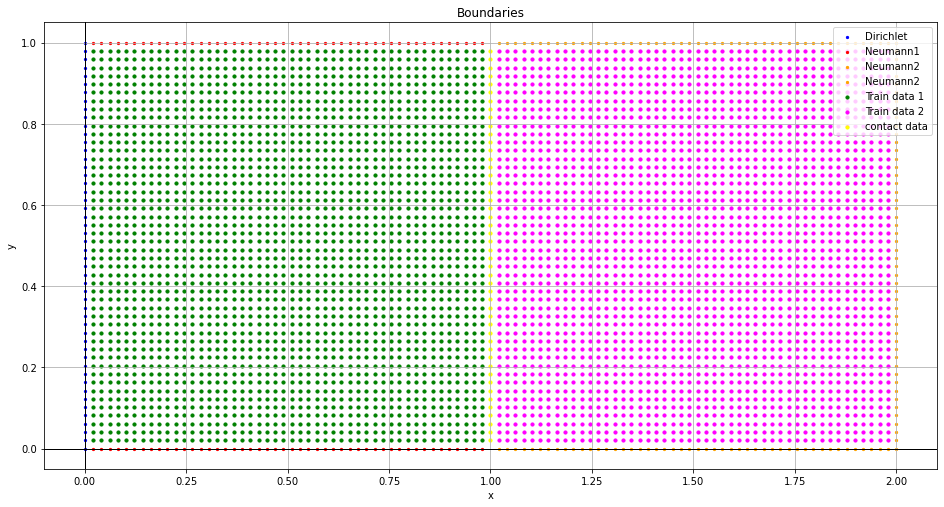

In [11]:
# Krok 3: Vygenerování trénovacích dat
(pts_interior_L, pts_interior_R, pts_neumann_L, pts_neumann_R, pts_dirichlet_L, pts_dirichlet_R, pts_contact, grad_mat_x, grad_mat_y, normals_L_neumann, normals_L_contact) = sample_points(50)

In [12]:
# Krok 4: Inicializace NN a nastavení optimalizátoru
NN1 = MyModel()
NN2 = MyModel()

optimizer = optim.Adam(list(NN1.parameters()) + list(NN2.parameters()), lr=0.001)
#optimizer_L = optim.Adam(NN1.parameters(), lr=0.001)
#optimizer_R = optim.Adam(NN2.parameters(), lr=0.001)

In [ ]:
# Krok 5.1: Trénovací smyčka
epochs = 200
loss_values = []
for epoch in range(epochs):
    #loss_L = optimizer_L.step(closure_L)  # LBFGS requires closure
    #loss_R = optimizer_R.step(closure_R)  # LBFGS requires closure
    loss = optimizer.step(closure)
    loss_values.append(loss)
    if epoch == epochs/2:
        #optimizer_L = torch.optim.LBFGS(NN1.parameters(), lr=0.1, max_iter=20, history_size=10)
        #optimizer_R = torch.optim.LBFGS(NN2.parameters(), lr=0.1, max_iter=20, history_size=10)
        optimizer = torch.optim.LBFGS(list(NN1.parameters()) + list(NN2.parameters()), lr=0.1, max_iter=20, history_size=10)

    if (epoch + 1) % 20 == 0:
        #print(f'Epoch {epoch+1}/{epochs}, Loss_L: {loss_L.item()}')
        #print(f'Epoch {epoch+1}/{epochs}, Loss_R: {loss_R.item()}')
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 20/200, Loss: 0.9702231287956238
Epoch 40/200, Loss: 0.803585946559906
Epoch 60/200, Loss: 0.4961416721343994
Epoch 80/200, Loss: 0.4185631275177002
Epoch 100/200, Loss: 0.3546467423439026
Epoch 120/200, Loss: 0.00833065900951624


In [97]:
# Krok 5.2: Graf znázorňující závislost ztráty na počtu epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_values, color='blue', linewidth=2)
plt.yscale('log')
plt.title('Závislost ztrátové funkce na počtu epoch')
plt.xlabel('Epocha')
plt.ylabel('Ztráta')
plt.grid(True)
plt.show()

In [98]:
def plot_predictions_random(points_combined_np, u_pred_combined_np):
    plt.figure(figsize=(8, 6))
    plt.scatter(points_combined_np[:,0:1], points_combined_np[:,1:2], c =u_pred_combined_np, cmap='jet', s=30)
    plt.colorbar(label='u_pred')
    plt.title('NN Prediction on Random Points Inside Unit Circle')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

    # Ensure proper shapes for the combined tensors
    x_combined = points_combined_np[:, 0]
    y_combined = points_combined_np[:, 1]
    z_combined = u_pred_combined_np.flatten()  # Ensure z values are 1D

    # Check the length consistency
    assert len(x_combined) == len(y_combined) == len(z_combined), "Shapes of x, y, and z must match."

    # Create 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    sc = ax.scatter(
        x_combined, y_combined, z_combined, 
        c=z_combined, cmap='jet', s=10
    )
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, shrink=0.5, pad=0.1)
    cbar.set_label('u_pred')

    # Labels and title
    ax.set_title('3D NN Prediction')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$u_{pred}$")

    plt.show()

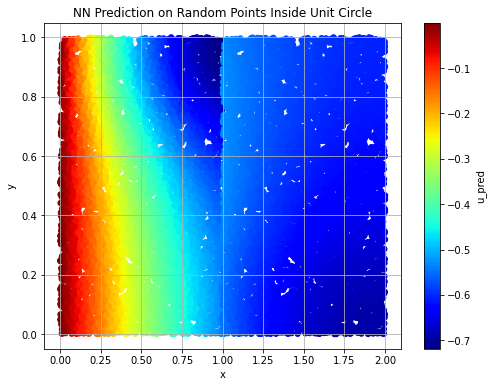

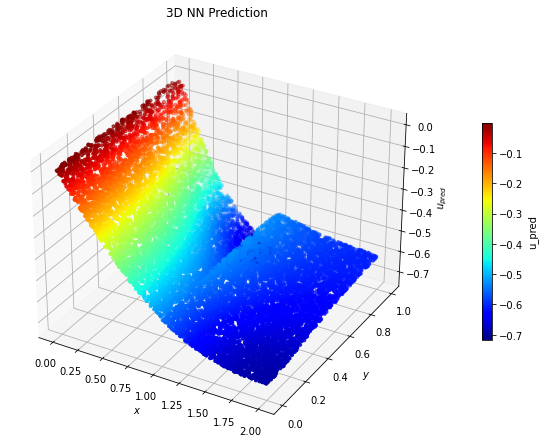

In [99]:
x_test = torch.rand(7000, 1)
y_test = torch.rand(7000, 1)

with torch.no_grad():
    # Left membrane
    inputs = torch.cat([x_test, y_test], dim=1)
    u_pred = NN1(inputs)

    # Right membrane
    inputs_R = torch.cat([x_test + 1, y_test], dim=1)  # Shift x-coordinates for the right membrane
    u_pred_R = NN2(inputs_R)

    u_pred = x_test * u_pred


# Combine points and predictions
points_combined = torch.cat([inputs, inputs_R], dim=0)  # Combine points
u_pred_combined = torch.cat([u_pred, u_pred_R], dim=0)  # Combine predictions

# Convert to NumPy for visualization or further processing
points_combined_np = points_combined.numpy()
u_pred_combined_np = u_pred_combined.numpy()

plot_predictions_random(points_combined_np, u_pred_combined_np)

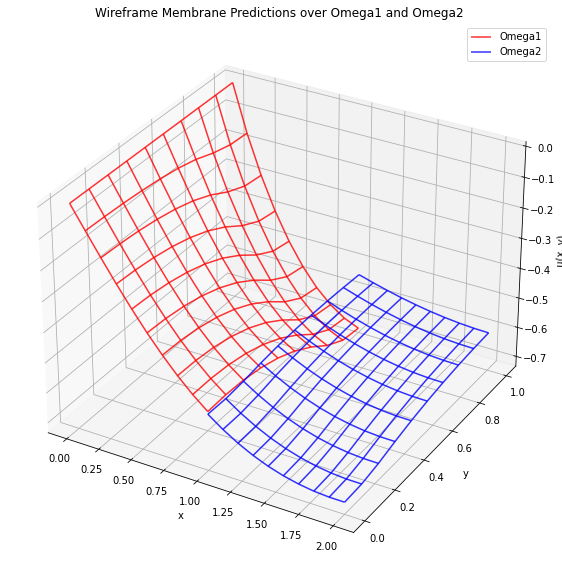

In [ ]:
# Krok 6.1: Vykreslení predikcí na náhodně rozložených datech
num_points = 25
# Define equally spaced points within Omega1: domain (0,1)x(0,1)
x1_lin = torch.linspace(0, 1, num_points)  # Equally spaced x-coordinates in [0,1]
y1_lin = torch.linspace(0, 1, num_points)  # Equally spaced y-coordinates in [0,1]
x1_grid, y1_grid = torch.meshgrid(x1_lin, y1_lin)    # Create a grid of points
Omega1 = torch.stack((x1_grid.flatten(), y1_grid.flatten()), dim=1)  # Flatten to Nx2 matrix

# Define equally spaced points within Omega2: domain (1,2)x(0,1)
x2_lin = torch.linspace(1, 2, num_points)  # Equally spaced x-coordinates in [1,2]
y2_lin = torch.linspace(0, 1, num_points)  # Equally spaced y-coordinates in [0,1]
x2_grid, y2_grid = torch.meshgrid(x2_lin, y2_lin)   # Create a grid of points
Omega2 = torch.stack((x2_grid.flatten(), y2_grid.flatten()), dim=1)  # Flatten to Nx2 matrix  # Adjust for grid density as desired

# Flatten Omega1 and Omega2 test sets to match network input expectations
Omega1_test = Omega1.reshape(-1, 2)  # Reshape to (num_points^2, 2)
Omega2_test = Omega2.reshape(-1, 2)

# Get predictions from both networks
with torch.no_grad():
    pred_Omega1 = NN1(Omega1_test).squeeze().numpy()
    pred_Omega2 = NN2(Omega2_test).squeeze().numpy()
    pred_Omega1 = Omega1_test[:, 0].numpy() * pred_Omega1

# Extract x and y values for each domain and match shapes
Omega1_x, Omega1_y = Omega1_test[:, 0].numpy(), Omega1_test[:, 1].numpy()
Omega2_x, Omega2_y = Omega2_test[:, 0].numpy(), Omega2_test[:, 1].numpy()

# Define uniform grids for interpolation
grid_size = 10
x1_grid, y1_grid = np.meshgrid(np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size))  # Adjust grid_size as desired
x2_grid, y2_grid = np.meshgrid(np.linspace(1, 2, grid_size), np.linspace(0, 1, grid_size))

# Interpolate predictions onto the uniform grids
z1_grid = griddata((Omega1_x, Omega1_y), pred_Omega1, (x1_grid, y1_grid), method='cubic')
z2_grid = griddata((Omega2_x, Omega2_y), pred_Omega2, (x2_grid, y2_grid), method='cubic')

# Set up 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot Omega1 as a red wireframe
ax.plot_wireframe(x1_grid, y1_grid, z1_grid, color='red', label='Omega1', alpha=0.8, linewidth=1.5)

# Plot Omega2 as a blue wireframe
ax.plot_wireframe(x2_grid, y2_grid, z2_grid, color='blue', label='Omega2', alpha=0.8, linewidth=1.5)

# Customize labels and title
ax.set_title("Wireframe Membrane Predictions over Omega1 and Omega2")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x, y)")

# Add a legend
ax.legend()

# Show the plot
plt.show()